# Differentially Private Ad Conversion Measurement Prototype

This notebook is an expanded prototype inspired by the study:

> **Differentially Private Ad Conversion Measurement**  
> John Delaney, Badih Ghazi, Charlie Harrison, Christina Ilvento, Ravi Kumar, Pasin Manurangsi, Martin Pál, Karthik Prabhakar, Mariana Raykova
> 
> *Proceedings on Privacy Enhancing Technologies 2024*

The goal of this notebook is to demonstrate, in a simplified setting, some of the core concepts discussed in the paper:

- **Ad conversion measurement:** Simulating impressions and conversions for users across publishers.
- **Attribution rules:** How to assign conversion credit to ad impressions. We implement several rules (LTA, FTA, Uniform, Exponential decay, and U-Shaped).
- **Contribution bounding:** A simplified mechanism to limit the impact of any single user (or impression) on the final measurement.
- **Differential Privacy:** Adding Laplace noise (calibrated to a privacy parameter \(\epsilon\)) to the aggregated conversion counts.

This notebook is meant as a prototype to showcase how these ideas can be implemented in a machine learning / data science project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# For reproducibility
np.random.seed(42)

## 1. Simulating Ad Impressions and Conversions

We simulate a small dataset with the following assumptions:

- **Users:** A number of users each viewing a random number of ad impressions (each from one of several publishers).
- **Impressions:** Each impression has a timestamp and is associated with a publisher and a single advertiser.
- **Conversions:** With some probability a user converts after their last impression.

This is a simplified simulation intended for demonstration purposes.

In [2]:
# Simulation parameters
num_users = 50
num_publishers = 5
advertiser = "Advertiser1"

impressions_list = []
conversions_list = []

# For each user, simulate a sequence of impressions
for user_id in range(num_users):
    # Each user sees between 1 and 5 impressions
    num_impressions = np.random.randint(1, 6)
    # Start time for this user's session
    start_time = pd.Timestamp("2024-01-01")
    for i in range(num_impressions):
        # Add a random offset in minutes
        time_offset = pd.Timedelta(minutes=np.random.randint(1, 60))
        impression_time = start_time + time_offset
        start_time = impression_time  # ensure impressions are in order
        publisher = f"Publisher_{np.random.randint(1, num_publishers+1)}"
        impressions_list.append({
            "user_id": user_id,
            "advertiser": advertiser,
            "publisher": publisher,
            "impression_time": impression_time
        })
    
    # With 70% chance, the user converts after the last impression
    if np.random.rand() < 0.7:
        conversion_time = start_time + pd.Timedelta(minutes=np.random.randint(1, 60))
        conversions_list.append({
            "user_id": user_id,
            "advertiser": advertiser,
            "conversion_time": conversion_time
        })

# Create DataFrames
impressions_df = pd.DataFrame(impressions_list)
conversions_df = pd.DataFrame(conversions_list)

print("Impressions Data Sample:")
print(impressions_df.head())

print("\nConversions Data Sample:")
print(conversions_df.head())

Impressions Data Sample:
   user_id   advertiser    publisher     impression_time
0        0  Advertiser1  Publisher_3 2024-01-01 00:29:00
1        0  Advertiser1  Publisher_5 2024-01-01 00:37:00
2        0  Advertiser1  Publisher_2 2024-01-01 00:58:00
3        0  Advertiser1  Publisher_3 2024-01-01 01:17:00
4        1  Advertiser1  Publisher_3 2024-01-01 00:40:00

Conversions Data Sample:
   user_id   advertiser     conversion_time
0        0  Advertiser1 2024-01-01 02:10:00
1        1  Advertiser1 2024-01-01 01:55:00
2        2  Advertiser1 2024-01-01 00:56:00
3        3  Advertiser1 2024-01-01 01:31:00
4        4  Advertiser1 2024-01-01 02:43:00


## 2. Attribution Rules

In ad conversion measurement the **attribution rule** determines how the credit for a conversion is split among the preceding impressions. 

Below are simplified implementations of several rules:

- **Last-Touch Attribution (LTA):** All credit goes to the last impression before the conversion.
- **First-Touch Attribution (FTA):** All credit goes to the first impression before the conversion.
- **Uniform Attribution (UNI):** Credit is split equally among all impressions before the conversion.
- **Exponential Decay (EXP):** Credit decays exponentially with the time difference between the impression and the conversion (using a given half-life).
- **U-Shaped Attribution (U-S):** For three or more impressions, the first and last impressions each receive 40% of the credit, and the remaining credit is shared equally among the intermediate impressions.

Each function takes a list of impression timestamps (assumed sorted) and a conversion timestamp, and returns a list of weights (which sum to 1).

In [3]:
def lta_attribution(impressions, conversion_time):
    """Last-Touch Attribution: assign full credit to the last impression before conversion."""
    valid_impressions = [imp for imp in impressions if imp < conversion_time]
    if not valid_impressions:
        return []
    weights = [0] * len(valid_impressions)
    weights[-1] = 1.0
    return weights

def fta_attribution(impressions, conversion_time):
    """First-Touch Attribution: assign full credit to the first impression before conversion."""
    valid_impressions = [imp for imp in impressions if imp < conversion_time]
    if not valid_impressions:
        return []
    weights = [0] * len(valid_impressions)
    weights[0] = 1.0
    return weights

def uni_attribution(impressions, conversion_time):
    """Uniform Attribution: split credit equally among all impressions before conversion."""
    valid_impressions = [imp for imp in impressions if imp < conversion_time]
    if not valid_impressions:
        return []
    n = len(valid_impressions)
    return [1.0/n] * n

def exp_attribution(impressions, conversion_time, half_life=10):
    """Exponential decay attribution: weight decreases exponentially with time gap."""
    valid_impressions = [imp for imp in impressions if imp < conversion_time]
    if not valid_impressions:
        return []
    weights = []
    for imp in valid_impressions:
        # Compute time difference in minutes
        delta = (conversion_time - imp).total_seconds() / 60.0
        weight = 0.5 ** (delta / half_life)
        weights.append(weight)
    total = sum(weights)
    if total == 0:
        return [0] * len(weights)
    return [w/total for w in weights]

def u_shaped_attribution(impressions, conversion_time):
    """U-Shaped Attribution: for 3+ impressions, first and last get 40% each, intermediate impressions share 20%."""
    valid_impressions = [imp for imp in impressions if imp < conversion_time]
    n = len(valid_impressions)
    if n == 0:
        return []
    if n == 1:
        return [1.0]
    if n == 2:
        return [0.5, 0.5]
    # For n >= 3
    weights = [0.4] + [0.2/(n-2)] * (n-2) + [0.4]
    return weights

# Example usage:
# Let's say a user saw three impressions at times t1, t2, t3 and converted at t_conv
# Uncomment the following lines to test:
# t1, t2, t3, t_conv = pd.Timestamp('2024-01-01 00:05'), pd.Timestamp('2024-01-01 00:15'), pd.Timestamp('2024-01-01 00:25'), pd.Timestamp('2024-01-01 00:35')
# print('LTA:', lta_attribution([t1, t2, t3], t_conv))
# print('FTA:', fta_attribution([t1, t2, t3], t_conv))
# print('UNI:', uni_attribution([t1, t2, t3], t_conv))
# print('EXP:', exp_attribution([t1, t2, t3], t_conv, half_life=10))
# print('U-S:', u_shaped_attribution([t1, t2, t3], t_conv))

## 3. Contribution Bounding Enforcement

In practical DP ad conversion measurement systems, it is important to limit the contribution
of any single user (or impression) so that the sensitivity of the query remains bounded.

In this simplified prototype, we simulate a **post-attribution contribution bound** by
capping the total conversion attribution weight per *(user, publisher)* pair. In more complex
systems (as described in the paper) the contribution bounding can be enforced either before (pre-)
or after (post-) applying the attribution rule, and may be defined over different scopes (e.g., user, user × advertiser, etc.).

In [4]:
def enforce_contribution_bound(attribution_dict, bound):
    """
    Given a dictionary with keys (user_id, publisher) and values representing total attribution weight,
    enforce a cap of 'bound' on each key.
    """
    bounded = {}
    for key, value in attribution_dict.items():
        bounded[key] = min(value, bound)
    return bounded

# For demonstration, we will later aggregate conversion attribution per publisher
# and then cap the contribution from each publisher (or per (user, publisher)) if desired.

## 4. Aggregating Conversion Attributions

For each conversion event, we look up the impressions for the same user (and advertiser) that occurred
before the conversion. We then apply an attribution rule (for example, LTA) to assign the conversion credit to one
or more impressions. In this example, we aggregate the attribution per publisher.

Below, we demonstrate a simple aggregation using the Last-Touch Attribution rule.

In [5]:
# First, group impressions by user (sorted by impression_time)
impressions_by_user = impressions_df.sort_values("impression_time").groupby("user_id")

attribution_records = []

# For each conversion, attribute it using impressions from the same user
for idx, conversion in conversions_df.iterrows():
    user = conversion["user_id"]
    conv_time = conversion["conversion_time"]
    
    if user in impressions_by_user.groups:
        user_impressions = impressions_by_user.get_group(user)
        # Extract impression times and corresponding publishers
        imp_times = list(user_impressions["impression_time"])
        publishers = list(user_impressions["publisher"])
        
        # Apply an attribution rule (here: Last-Touch Attribution)
        weights = lta_attribution(imp_times, conv_time)
        
        if weights:
            # For LTA, the last impression gets full credit
            index = len(weights) - 1
            attribution_records.append({
                "user_id": user,
                "publisher": publishers[index],
                "attribution": weights[index]
            })

attribution_df = pd.DataFrame(attribution_records)
print("Attribution Data Sample:")
print(attribution_df.head())

Attribution Data Sample:
   user_id    publisher  attribution
0        0  Publisher_3          1.0
1        1  Publisher_2          1.0
2        2  Publisher_2          1.0
3        3  Publisher_3          1.0
4        4  Publisher_3          1.0


## 5. Adding Differential Privacy via the Laplace Mechanism

To release the aggregated conversion counts without compromising individual privacy, we add noise
using the Laplace mechanism. Here, the sensitivity of a count query is assumed to be 1 and the noise scale is
calibrated by the privacy parameter \(\epsilon\). 

Below, we first aggregate the total conversion attribution per publisher and then add Laplace noise to each count.

In [6]:
def laplace_mechanism(true_value, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return true_value + noise

# Differential privacy parameter
epsilon = 1.0

# Aggregate conversion attribution counts by publisher
agg_true = attribution_df.groupby("publisher")["attribution"].sum().reset_index()
agg_true.columns = ["publisher", "true_attribution"]

# Apply the Laplace mechanism to each aggregated count
agg_true["dp_attribution"] = agg_true["true_attribution"].apply(lambda x: laplace_mechanism(x, epsilon))

print("Aggregated True and DP Attributions:")
print(agg_true)

Aggregated True and DP Attributions:
     publisher  true_attribution  dp_attribution
0  Publisher_1               6.0        6.033963
1  Publisher_2              10.0       10.377202
2  Publisher_3               5.0        4.862284
3  Publisher_4               6.0        6.616332
4  Publisher_5               4.0        1.650661


## 6. Visualization

We now compare the true aggregated conversion attributions with the differentially private (DP) estimates
by plotting a bar chart for each publisher.

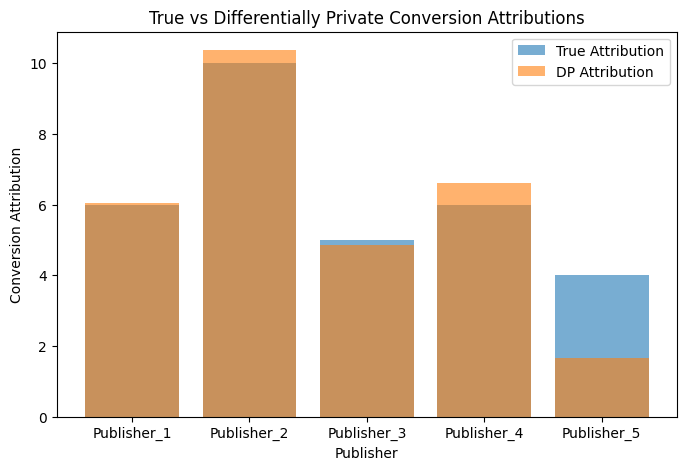

In [7]:
plt.figure(figsize=(8,5))
plt.bar(agg_true["publisher"], agg_true["true_attribution"], alpha=0.6, label="True Attribution")
plt.bar(agg_true["publisher"], agg_true["dp_attribution"], alpha=0.6, label="DP Attribution")
plt.xlabel("Publisher")
plt.ylabel("Conversion Attribution")
plt.title("True vs Differentially Private Conversion Attributions")
plt.legend()
plt.show()

## 7. Conclusion and Future Directions

This notebook demonstrated a simplified prototype for a differentially private ad conversion
measurement system inspired by the study by Delaney et al. We simulated ad impressions and conversions, 
applied several attribution rules, enforced a simple contribution bound, and finally added Laplace noise 
to the aggregated conversion counts to ensure differential privacy.

### Possible Extensions

- **Attribution Rules:** Implement and compare additional rules such as Exponential decay (EXP) or more advanced
  multi-touch attribution methods.
- **Contribution Bounding:** Explore pre-attribution contribution bounding and more complex scopes (e.g., user × advertiser).
- **Privacy Mechanisms:** Experiment with other DP mechanisms (e.g., Gaussian noise, advanced composition, or mechanisms
  for approximate DP).
- **Real Data:** Apply the prototype to real ad conversion datasets and study the trade-offs between privacy and utility.

This project serves as a demonstration of applying differential privacy concepts in the business domain of ad
conversion measurement and can be extended further for research or as a portfolio project to showcase expertise in
machine learning and privacy-preserving data analysis.